In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# Number of classes

In [25]:
NUM_CLASSES = 8

# Reading training data

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 8)                 88        
                                                                 
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# fit the model

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
62/70 [=========================>....] - ETA: 0s - loss: 1.8776 - accuracy: 0.3707
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
70/70 [==============================] - 1s 5ms/step - loss: 1.8572 - accuracy: 0.3804 - val_loss: 1.4576 - val_accuracy: 0.5909
Epoch 2/1000
59/70 [========================>.....] - ETA: 0s - loss: 1.4696 - accuracy: 0.5470
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.4480 - accuracy: 0.5509 - val_loss: 1.0748 - val_accuracy: 0.6836
Epoch 3/1000
59/70 [========================>.....] - ETA: 0s - loss: 1.1999 - accuracy: 0.6050
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
70/70 [==============================] - 0s 3ms/step - loss: 1.1865 - accuracy: 0.6091 - val_loss: 0.8667 - val_accuracy: 0.7329
Epoch 4/1000
46/70 [==================>...........] - ETA: 0s - loss: 1.0480 - accuracy: 0.6442
E

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 1ms/step - loss: 0.0551 - accuracy: 0.9879


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Model prediction - Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 49ms/step
[3.6376126e-03 1.9078458e-02 7.6990001e-36 9.7728390e-01 3.4658193e-36
 1.5883927e-26 0.0000000e+00 6.2374495e-31]
3


# mixed row

93/93 [==============================] - 0s 848us/step


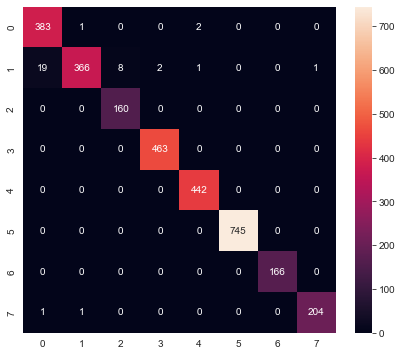

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       386
           1       0.99      0.92      0.96       397
           2       0.95      1.00      0.98       160
           3       1.00      1.00      1.00       463
           4       0.99      1.00      1.00       442
           5       1.00      1.00      1.00       745
           6       1.00      1.00      1.00       166
           7       1.00      0.99      0.99       206

    accuracy                           0.99      2965
   macro avg       0.99      0.99      0.99      2965
weighted avg       0.99      0.99      0.99      2965



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transforming the model (quantization)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\admin\AppData\Local\Temp\tmph800d847\assets


6692

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.6376095e-03 1.9078387e-02 7.6990016e-36 9.7728401e-01 3.4657662e-36
 1.5883990e-26 0.0000000e+00 6.2374020e-31]
3
